In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.ldamodel import LdaModel
# from data_preprocessing import *
# from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

In [ ]:
train_df = pd.read_csv('train.txt',sep=";", header= None, names=["text", "label"])

In [ ]:
train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
train_df["label"].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text
    
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [ ]:
def clean_text(text):
    text = lower_text(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    
    return text

In [ ]:
train_df["clean_text"] = train_df["text"].apply(clean_text)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df["encoded_train_label"] = label_encoder.fit_transform(train_df["label"])

In [ ]:
train_df[['label', 'encoded_train_label']].drop_duplicates(keep='first')

,label,encoded_train_label
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X=train_df['clean_text']

In [ ]:
X[0]

'didnt feel humiliated'

In [ ]:
y=train_df['encoded_train_label']

In [ ]:
y[0]

4

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sentences_ted = []
for sent_str in X_train:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)
for sent_str in X_test:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

In [ ]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

EPOCHS= 30
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# #TEST = tokenizer.texts_to_sequences(test_df["clean_text"]) 

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

13380

In [ ]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)
print('Max len:', maxlen)

Max len: 35


In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
sentences_ted

[['refers',
  'course',
  'though',
  'cant',
  'help',
  'feeling',
  'somehow',
  'ironically',
  'retrospect',
  'loudons',
  'son',
  'kate',
  'mcgarrigle',
  'rather',
  'talented',
  'rufus',
  'wainwright'],
 ['im', 'starting', 'feel', 'im', 'suffering', 'fatigue'],
 ['feel',
  'like',
  'probably',
  'would',
  'liked',
  'book',
  'little',
  'bit',
  'simple',
  'story',
  'line'],
 ['really', 'feel', 'awkward'],
 ['im',
  'feeling',
  'little',
  'grumpy',
  'today',
  'lame',
  'weather',
  'tease',
  'got',
  'weekend'],
 ['realized', 'ignoring', 'better', 'heartbreaking', 'feel', 'helpless'],
 ['dark', 'chocolate', 'may', 'square', 'im', 'feeling', 'need', 'sweet'],
 ['believe',
  'people',
  'use',
  'fulsome',
  'manners',
  'social',
  'reasons',
  'top',
  'scale',
  'human',
  'evolution',
  'feel',
  'hurt',
  'fake',
  'behavior'],
 ['feel',
  'like',
  'less',
  'faithful',
  'less',
  'worthy',
  'less',
  'loving',
  'less',
  'able'],
 ['feel',
  'peaceful',
 

In [ ]:
from gensim.models import FastText
model_ted = FastText(sentences_ted, size=300, window=5, min_count=5, workers=4,sg=1)

In [ ]:
model_ted

In [ ]:
model_ted.wv["man"]

array([-0.0164718 ,  0.1315936 ,  0.05784084,  0.0073905 ,  0.00190733,
        0.06010333, -0.2168695 , -0.10463648, -0.05678274, -0.01462288,
       -0.12765552,  0.1541963 ,  0.07937367, -0.11601067,  0.08876257,
        0.00311227,  0.02158518, -0.00206302,  0.04122613, -0.00588219,
       -0.33572793, -0.00186677, -0.03827535,  0.01316081,  0.15476182,
       -0.04983736, -0.12297227, -0.02133152,  0.16168575,  0.16279805,
        0.0372767 , -0.02304227, -0.06024696, -0.09418349,  0.09661406,
       -0.03545666, -0.09014677,  0.08239584,  0.02311429,  0.10149896,
        0.0185151 ,  0.00377123,  0.02549529,  0.01405777,  0.02166322,
       -0.08123484, -0.06491428,  0.05942119, -0.05743301, -0.00953924,
        0.09687457,  0.10186839,  0.03483357,  0.06014349, -0.14636002,
       -0.01695889,  0.11061543, -0.04348576, -0.00996322, -0.01287366,
       -0.10595627,  0.0327762 , -0.10667419, -0.047102  ,  0.11829031,
        0.02566183,  0.08128686, -0.16432832,  0.06797518, -0.08

In [ ]:
# def get_embedding_vectors(tokenizer, dim=300):
#     embedding_index = {}
#     with open('../input/glove840b300dtxt/glove.840B.300d.txt','r') as f:
#         for line in tqdm.tqdm(f, "Reading GloVe"):
#             values = line.split()
#             word = ''.join(values[:-300])
#             vectors = np.asarray(values[-300:], dtype='float32')
#             embedding_index[word] = vectors

#     word_index = tokenizer.word_index
#     embedding_matrix = np.zeros((len(word_index)+1, dim))
#     for word, i in word_index.items():
#         embedding_vector = embedding_index.get(word)
#         if embedding_vector is not None:
#             # words not found will be 0s
#             embedding_matrix[i] = embedding_vector
          
#     return embedding_matrix

In [ ]:
type(model_ted)

gensim.models.fasttext.FastText

In [ ]:
# embedding_matrix_ft.shape

In [ ]:
# import fasttext


In [ ]:
# word_index = tokenizer.word_index
# embedding_matrix2 = np.zeros((len(word_index)+1, 100))
# for word, i in word_index.items():
#     embedding_vector = model_ted.wv[word]
#     if embedding_vector is not None:
#         # words not found will be 0s
#         embedding_matrix2[i] = embedding_vector

In [ ]:
word_index = tokenizer.word_index
embedding_matrix3 = np.random.random((vocab_size, 300))
for word,i in word_index.items():
    try:
        embedding_vector = model_ted.wv[word]
    except:
        print(word, 'not found')
    if embedding_vector is not None:
        embedding_matrix3[i] = embedding_vector

bf not found
aa not found
hmmm not found
yuuki not found
msg not found
j not found
dm not found
nyc not found
xx not found
tsa not found
km not found
ltr not found
uh not found
vs not found
ml not found
kg not found
pb not found
yu not found
h not found
gm not found
btw not found
wtf not found
bbq not found
dh not found
hp not found
hmm not found
zz not found
wu not found
dc not found
cx not found
aoa not found
gw not found
xvi not found
hd not found
xl not found
kj not found
ebb not found
cbc not found
mxm not found
md not found
rv not found
kai not found
bsc not found
l not found
dt not found
qq not found
nl not found
bbc not found
mm not found
lsd not found
vj not found
aj not found
pc not found
tx not found
nw not found
gmc not found
khi not found
tl not found
eh not found
kx not found
sd not found
z not found
zq not found
uv not found
hmmmmm not found
nvm not found
ghd not found
cgi not found
bm not found
tbh not found
sxe not found
ccw not found
hb not found
aac not found
wt not 

In [ ]:
embedding_matrix=embedding_matrix3
embedding_matrix.shape

(13380, 300)

In [ ]:
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=13380, output_dim=embedding_dim, weights = [embedding_matrix], input_length=35))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 35, 300)           4014000   
                                                                 
 dropout_40 (Dropout)        (None, 35, 300)           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 33, 32)            28832     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 11, 32)           0         
 g1D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 11, 32)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 9, 32)             3104      
                                                     

In [ ]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [ ]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/30
100/100 [==============================] - 23s 196ms/step - loss: 1.5912 - accuracy: 0.3248 - val_loss: 1.6120 - val_accuracy: 0.2988
Epoch 2/30
100/100 [==============================] - 19s 193ms/step - loss: 1.5607 - accuracy: 0.3567 - val_loss: 1.4520 - val_accuracy: 0.3819
Epoch 3/30
100/100 [==============================] - 26s 258ms/step - loss: 1.1260 - accuracy: 0.5730 - val_loss: 0.9310 - val_accuracy: 0.6019
Epoch 4/30
100/100 [==============================] - 21s 204ms/step - loss: 0.6960 - accuracy: 0.7131 - val_loss: 0.5495 - val_accuracy: 0.7766
Epoch 5/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4367 - accuracy: 0.8313 - val_loss: 0.4423 - val_accuracy: 0.8347
Epoch 6/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3187 - accuracy: 0.8860 - val_loss: 0.3688 - val_accuracy: 0.8794
Epoch 7/30
100/100 [==============================] - 19s 190ms/step - loss: 0.2434 - accuracy: 0.9148 - val_loss: 0.3962 - val_ac

In [ ]:
dummy_y_train.shape

(12800, 6)

In [ ]:
len(word_index)

13379

In [ ]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

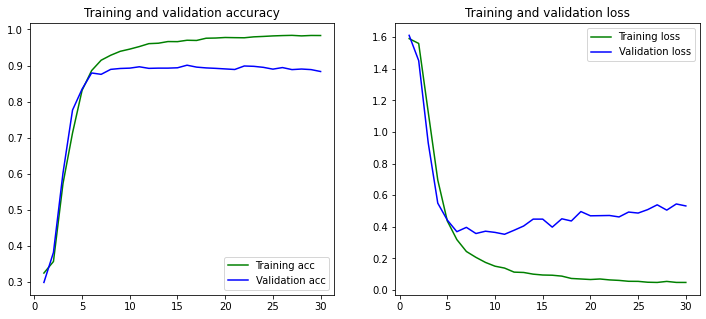

In [ ]:
PlotGraph(history)


In [ ]:
# input_len=35
# input_dim1=13380
# embedding_dim1=300

In [ ]:
# import keras
# from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D
# from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
# from tensorflow.keras import Sequential, Model
# Input1 = Input(shape=(input_len,))
# Embedding_layer1 = Embedding(input_dim=input_dim1, 
#                              output_dim=embedding_dim1, 
#                              weights=[embedding_matrix], 
#                              trainable=False)(Input1)
# # np.resize(Embedding_layer1,(35,300))
# Embedding_layer1.shape


TensorShape([None, 100, 300])

In [1]:
# Lstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(Embedding_layer1)
# Conv1 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(Embedding_layer1)
# Dropout1 = Dropout(0.3)(Conv1)
# Conv2 = Conv1D(filters=256, kernel_size=4, activation='relu', padding='same')(Embedding_layer1)
# Dropout2 = Dropout(0.3)(Conv2)
# Conv3 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(Embedding_layer1)
# Dropout3 = Dropout(0.3)(Conv3)
# merged = concatenate([Dropout1, Dropout2, Dropout3], axis=1)
# max_pool = MaxPooling1D(pool_size=3)(merged)
# conc = AttentionLayer()([Lstm, max_pool])
# # conc = concatenate([Lstm, max_pool], axis=1)
# Dense1 = Dense(64, activation='relu')(conc)
# Dropout_dense = Dropout(0.25)(Dense1)
# outputs = Dense(6, activation='softmax')(Dropout_dense)
# classifier = Model(inputs=Input1, outputs=outputs)
# classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# classifier.summary()

In [2]:
# from tensorflow.keras.utils import plot_model
# plot_model(classifier, show_shapes=False)


In [ ]:
# checkpoint_filepath = "../models/multi-channel-LSTM-CNN-epoch-{epoch:02d}-val-acc-{val_acc:02f}.h5"
# model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
#                                             save_weights_only=True,
#                                             monitor='val_acc',
#                                             mode='max',
#                                             save_freq = 'epoch',
#                                             save_best_only=True)

# # Reduce Learning Rate on Plateau Callback:
# reduce_lr_callback = ReduceLROnPlateau( monitor='val_acc', 
#                                        factor=0.1, 
#                                        patience=2, 
#                                        min_lr=0.0005, 
#                                        verbose=2)

In [3]:
# history = classifier.fit(X_train, 
#                          dummy_y_train, 
#                          epochs=16,
#                          batch_size=128,
#                          verbose=1,
#                         validation_data=(X_test, dummy_y_test),
#                         callbacks=[model_checkpoint_callback, reduce_lr_callback])

In [4]:
# dummy_y_train.shape

In [5]:
# X_train.shape

In [ ]:
# class AttentionLayer(Layer):
    
#     def __init__(self, **kwargs):
#         super(AttentionLayer, self).__init__(**kwargs)
        
        
#     def build(self, attention_input):
#         super(AttentionLayer, self).build(attention_input)
#         lstm_shape, cnn_shape = attention_input
#         # Attention Weights for LSTM
#         self.W_in = self.add_weight(shape=(lstm_shape[-1], 1),
#                                     initializer='glorot_normal',
#                                     trainable=True,
#                                     name='input_attention_weights')
        
#         # Attention Weights for CNN
#         self.W_context = self.add_weight(shape=(cnn_shape[-1], 1),
#                                          initializer='glorot_normal',
#                                          trainable=True,
#                                          name='context_attention_weights')
                                      
#         # Attention Bias
#         self.b = self.add_weight(shape=(lstm_shape[1], 1),
#                                  initializer='glorot_normal',
#                                  trainable=True,
#                                  name='attention_bias')
        
        
        
#     def call(self, attention_input):
#         lstm_output, cnn_output = attention_input
#         et = K.squeeze(K.tanh(K.dot(lstm_output, self.W_in) + 
#                               K.dot(cnn_output, self.W_context) +
#                               self.b), axis=-1)
#         at = K.expand_dims(K.softmax(et), axis=-1)
#         attention_output = at * lstm_output
#         attention_output = K.sum(attention_output, axis=1)
#         return attention_output
    
#     def get_config(self):
#         return super(AttentionLayer, self).get_config()

In [ ]:
# input_len=35
# input_dim1=13380
# embedding_dim1=300

In [ ]:
# import keras
# from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D
# from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
# from tensorflow.keras import Sequential, Model
# Input1 = Input(shape=(input_len,))
# Embedding_layer1 = Embedding(input_dim=input_dim1, 
#                              output_dim=embedding_dim1, 
#                              weights=[embedding_matrix], 
#                              trainable=False)(Input1)

In [6]:
# Lstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(Embedding_layer1)
# Lstm = Flatten()(Lstm)
# Lstm = Dense(64,activation='relu')(Lstm)
# convs = []
# filter_sizes = [3,4,5]
# for filter_size in filter_sizes:
#     l_conv = Conv1D(filters=200, 
#                     kernel_size=filter_size, 
#                     activation='relu')(Embedding_layer1)
#     l_pool = GlobalMaxPooling1D()(l_conv)
#     convs.append(l_pool)
# l_merge = concatenate(convs, axis=1)
# l_merge = Dense(64,activation='relu')(l_merge)
# conc = concatenate([Lstm, l_merge], axis=1)
# Dense1 = Dense(64, activation='relu')(conc)
# Dropout_dense = Dropout(0.25)(Dense1)
# outputs = Dense(6, activation='softmax')(Dropout_dense)
# classifier = Model(inputs=Input1, outputs=outputs)
# classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# classifier.summary()

In [ ]:
# checkpoint_filepath = './Checkpoint/checkpoint'
# model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
#                                             save_weights_only=True,
#                                             monitor='val_acc',
#                                             mode='max',
#                                             save_freq = 'epoch',
#                                             save_best_only=True)

# # Reduce Learning Rate on Plateau Callback:
# reduce_lr_callback = ReduceLROnPlateau( monitor='val_acc', 
#                                        factor=0.1, 
#                                        patience=2, 
#                                        min_lr=0.0005, 
#                                        verbose=2)

In [7]:
# history = classifier.fit(X_train, 
#                          dummy_y_train, 
#                          epochs=16,
#                          batch_size=128,
#                          verbose=1,
#                         validation_data=(X_test, dummy_y_test),
#                         callbacks=[model_checkpoint_callback, reduce_lr_callback])